# XGB-Transformer用于电力负荷预测

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sqlalchemy import create_engine
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBRegressor
from tqdm import tqdm

In [17]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

## 导入数据

In [18]:
# load data
url = '../dataset_0101110000.csv'
data = pd.read_csv(url, sep=',', index_col='time')

## 归一化

In [19]:
# 归一化
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    normalized_data = MinMaxScaler().fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[['load']])
    return normalized_data, scaler_y

## 特征选择

In [20]:
# 选择重要特征
def select_feature(X, feature_num=10):
    """
    X: features, size * 48 * features
    Y: labels, size *  1
    feature_num: num of selected features
    return: index of selected features
    """
    x = X[:, :-1]
    y = X[:, -1:]
    model = XGBRegressor()
    model.fit(x, y)
    model.importance_type = 'weight'
    ind = (-model.feature_importances_).argsort()[0:feature_num]
    ind = np.append(ind, -1)
    return X[:, ind]

## 构造监督数据集

In [21]:
# build supervised data
def Series_To_Supervise(data, seq_len, target_len, y_col_index):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of sequence
    :y_col_index: index of column which acts as output
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    #     pdb.set_trace()
    dim_0 = data.shape[0] - seq_len
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(dim_0):
        x[i] = data[i:i + seq_len]
        y[i] = data[i + seq_len - target_len:i + seq_len, y_col_index]
    print("Supervised Train Data: Shape of x: {}, Shape of y: {}".format(
        x.shape, y.shape))
    return x, y


def Series_To_Supervise_Test(data, seq_len, target_len, y_col_index):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of sequence
    :y_col_index: index of column which acts as output
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = int((data.shape[0] - seq_len) / 24) + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(0, dim_0):
        x[i] = data[i * 24:i * 24 + seq_len]
        y[i] = data[i * 24 + seq_len - target_len:i * 24 + seq_len,
                    y_col_index]
    print("Supervised Test Data: Shape of x: {}, Shape of y: {}".format(
        x.shape, y.shape))
    return x, y

## 5-折交叉验证

In [22]:
# 5-fold cross-validation
def split_dataset(X, Y, n_split=5):
    """
    X: original feature, size * 72 * features
    Y: labels, size * 1
    return: list of train_x, test_x, train_y, test_y
    """
    kf = KFold(n_splits=n_split, shuffle=True, random_state=1)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in kf.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, valid_x_list, train_y_list, valid_y_list

## 模型定义
### 位置编码层

In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### 生成mask

In [24]:
def generate_square_subsequent_mask(sz):
    """
    Generate a square mask for the sequence. The masked positions are filled with float(‘-inf’). Unmasked positions are filled with float(0.0).
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(
        mask == 1, float(0.0))
    return mask.to(device)

### Transformer定义

In [25]:
# define transformer
class Transformer(nn.Module):
    def __init__(self,
                 input_size=13,
                 d_model=64,
                 nhead=8,
                 n_layers=4,
                 dim_feedforward=32):
        super(Transformer, self).__init__()
        self.embedding = nn.Sequential(nn.Linear(input_size, d_model),
                                       nn.ReLU())
        # self.pe = PositionalEncoding(d_model=d_model)
        self.transformer = nn.Transformer(d_model=d_model,
                                          nhead=nhead,
                                          num_encoder_layers=n_layers,
                                          num_decoder_layers=n_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=0)
        self.out = nn.Linear(d_model, 1)

    def forward(self, src, tgt, is_tgt_mask=True):
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        # src = self.pe(src)
        # tgt = self.pe(tgt)
        if is_tgt_mask:
            tgt_mask = generate_square_subsequent_mask(tgt.shape[0])
            output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        else:
            output = self.transformer(src, tgt)
        output = self.out(output)
        return output

## 训练模型

In [26]:
# train the model
def train_model(train_x_list,
                train_y_list,
                valid_x_list,
                valid_y_list,
                input_size=23,
                d_model=8,
                nhead=4,
                n_layers=4,
                dim_feedforward=32,
                seq_len=48,
                target_len=24,
                number_epochs=40,
                batch_size=512,
                lr=0.01):
    transformer = Transformer(input_size, d_model, nhead, n_layers,
                              dim_feedforward)
    transformer.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(transformer.parameters(),
                                 lr=lr,
                                 betas=(0.9, 0.98),
                                 eps=1e-9)
    valid_loss_min = np.Inf
    for i in range(5):
        print('train dataset {}'.format(i))
        train_x = train_x_list[i]
        train_y = train_y_list[i]
        valid_x = valid_x_list[i]
        valid_y = valid_y_list[i]
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))

        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=20,
                                                    gamma=0.5)
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        train_losses = list()

        num_without_imp = 0

        # train
        for epoch in range(1, number_epochs + 1):
            loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
            for i, (inputs, labels) in loop:
                transformer.train()
                inputs = inputs.transpose(0, 1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # train
                # pdb.set_trace()
                input_tensor = inputs[0:seq_len, :, :]
                target_tensor = inputs[seq_len - 1:seq_len + target_len -
                                       1, :, :]
                outputs = transformer(input_tensor,
                                      target_tensor).squeeze().transpose(0, 1)
                loss = criterion(outputs, labels)
                train_losses.append(loss.item)
                loss.backward()
                optimizer.step()

                # eval
                if i % 5 == 0:
#                     if num_without_imp > 30:
#                         return transformer
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    transformer.eval()
                    for inp, lab in valid_loader:
                        inp = inp.transpose(0, 1)
                        inp = inp.to(device)
                        lab = lab.to(device)
                        input_tensor = inp[0:seq_len, :, :]
                        target_tensor = inp[seq_len - 1:seq_len + target_len -
                                            1, :, :]
                        out = transformer(input_tensor,
                                          target_tensor).squeeze().transpose(
                                              0, 1)
                        valid_loss = criterion(out, lab)
                        valid_losses.append(valid_loss.item())
                    loop.set_description("Epoch: {}/{}...".format(
                        epoch, number_epochs))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(transformer.state_dict(),
                                   "transformer_state_dict.pt")
                        valid_loss_min = np.mean(valid_losses)
            scheduler.step()
    return transformer

## 测试模型

In [27]:
# test the model
def test_model(transformer, test_x, test_y, batch_size, seq_len, target_len,
               scaler):
    # pdb.set_trace()
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
    transformer.load_state_dict(torch.load('transformer_state_dict.pt'))
    y_pred = list()
    y_true = list()
    y_index = test_x.shape[2] - 1
    transformer.eval()
    with torch.no_grad():
        transformer.eval()
        for inputs, labels in test_loader:
            inputs = inputs.transpose(0, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # encoder
            input_tensor = inputs[0:seq_len, :, :]
            target_tensor = inputs[seq_len - 1:seq_len + target_len - 1, :, :]
            outputs = transformer(input_tensor,
                                  target_tensor).squeeze().transpose(0, 1)
            y_pred = y_pred + outputs.reshape(-1).cpu().numpy().tolist()
            y_true = y_true + labels.reshape(-1).cpu().numpy().tolist()
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    load_true = scaler.inverse_transform(np.expand_dims(y_true, axis=1))
    load_pred = scaler.inverse_transform(np.expand_dims(y_pred, axis=1))
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## 定义超参数

In [28]:
# model configs
def Model_Configs():
    d_model = [16]
    nhead = [4]
    n_layers = [2]
    lr = [0.01]
    configs = list()
    for i in d_model:
        for j in nhead:
            for k in n_layers:
                for l in lr:
                    configs.append([i, j, k, l])
    return configs

## 主函数

In [29]:
def main(n_split=5, seq_len=48, target_len=24, batch_size=512):
    normalized_data, scaler_y = normalization(data)
    normalized_data = select_feature(normalized_data, feature_num=10)
    train_data = normalized_data[:-3000]
    test_data = normalized_data[-3000:]
    y_index = normalized_data.shape[1] - 1
    num_features = normalized_data.shape[1]
    x, y = Series_To_Supervise(train_data,
                               seq_len=seq_len + target_len,
                               target_len=target_len,
                               y_col_index=y_index)
    train_x_list, valid_x_list, train_y_list, valid_y_list = split_dataset(
        x, y, n_split=n_split)
    test_x, test_y = Series_To_Supervise_Test(test_data,
                                              seq_len=seq_len + target_len,
                                              target_len=target_len,
                                              y_col_index=y_index)
    configs = Model_Configs()
    MAPE_list = list()
    MAE_list = list()
    RMSE_list = list()
    for config in configs:
        d_model = config[0]
        nhead = config[1]
        n_layers = config[2]
        lr = config[3]
        print("Model Config: d_model--{}, nhead--{}, n_layers--{}, lr--{}".format(
            d_model, nhead, n_layers, lr))

        while (1):
            transformer = train_model(train_x_list,
                                      train_y_list,
                                      valid_x_list,
                                      valid_y_list,
                                      d_model=d_model,
                                      nhead=nhead,
                                      n_layers=n_layers,
                                      input_size=num_features,
                                      batch_size=batch_size,
                                      lr=lr,
                                      seq_len=seq_len,
                                      target_len=target_len)
            (MAPE, MAE, RMSE, load_pred,
             load_true) = test_model(transformer,
                                     test_x,
                                     test_y,
                                     batch_size=batch_size,
                                     seq_len=seq_len,
                                     target_len=target_len,
                                     scaler=scaler_y)
            if MAPE < 0.1:
                break
        MAPE_list.append(MAPE)
        MAE_list.append(MAE)
        RMSE_list.append(RMSE)
    return (MAPE_list, MAE_list, RMSE_list, load_pred, load_true, transformer)

## 运行

In [30]:
(MAPE_list, MAE_list, RMSE_list, load_pred, load_true, model) = main()

Supervised Train Data: Shape of x: (28587, 72, 11), Shape of y: (28587, 24)
Supervised Test Data: Shape of x: (123, 72, 11), Shape of y: (123, 24)
Model Config: d_model--16, nhead--4, n_layers--2, lr--0.01
train dataset 0


Epoch: 40/40...: 100%|██████████| 44/44 [00:07<00:00,  5.64it/s, train_loss=0.000169, valid_loss=0.000175]


train dataset 1


Epoch: 40/40...: 100%|██████████| 44/44 [00:07<00:00,  5.60it/s, train_loss=0.000111, valid_loss=0.000109]


train dataset 2


Epoch: 40/40...: 100%|██████████| 44/44 [00:07<00:00,  6.19it/s, train_loss=0.000102, valid_loss=0.000102]


train dataset 3


Epoch: 40/40...: 100%|██████████| 44/44 [00:07<00:00,  5.53it/s, train_loss=9.47e-5, valid_loss=9.48e-5]


train dataset 4


Epoch: 40/40...: 100%|██████████| 44/44 [00:08<00:00,  5.49it/s, train_loss=0.000101, valid_loss=9.58e-5]


RuntimeError: Error(s) in loading state_dict for Transformer:
	size mismatch for embedding.0.weight: copying a param with shape torch.Size([16, 23]) from checkpoint, the shape in current model is torch.Size([16, 11]).

In [20]:
MAPE_list, MAE_list, RMSE_list

([0.010824041595753436], [130.2979913840813], [180.6460178151366])

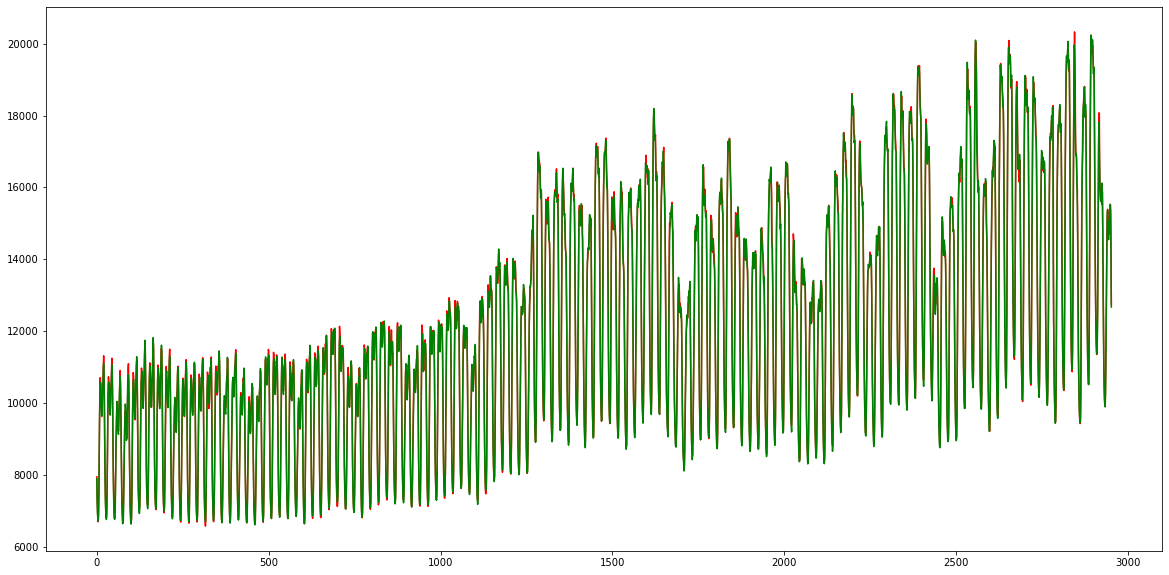

In [21]:
plt.figure(figsize=(20, 10))
plt.plot(load_pred, 'r')
plt.plot(load_true, 'g')

In [20]:
np.save('./load_pred_xgbtransformer.npy', load_pred)
np.save('./load_true_xgbtransformer.npy', load_true)
torch.save(model.state_dict(), "xgbtransformer_state_dict.pt")